##### setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns


df = pd.read_csv('../data/ind_turnover.csv')
df.head(3)
df['EmployeeNumber'].is_unique

True

In [2]:
def plot_corr_bar(df):
    corr = df.drop(columns=['Attrition']).corrwith(df['Attrition']).sort_values(ascending=False)
    corr = corr[corr.abs() > .075]
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(8, 6))
    sns.barplot(x=corr.values, y=corr.index, palette='viridis')
    plt.title('Feature Correlation with Attrition')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
def undersample(df, target_col='Attrition'):
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]

    df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    return df_balanced.sample(frac=1, random_state=42)  # Shuffle the dataset

def boolify_ints(df):
    df = df.copy()
    for col in df.select_dtypes(include=['int']).columns:
        if col == 'Attrition':
            continue
        # create bool for int >75 percentile and <25 percentile
        threshold_high = df[col].quantile(0.75)
        threshold_low = df[col].quantile(0.25)
        df[f'{col}_high'] = (df[col] > threshold_high).astype(int)
        df[f'{col}_low'] = (df[col] < threshold_low).astype(int)

        # drop original int column
        df.drop(columns=[col], inplace=True)
    return df

def plot_increased_odds_ratio(df, target_col='Attrition', threshold=1.5, distance_from_one=None, p_value_threshold=None):
    odds_ratios = {}
    p_values = {}
    
    for col in df.columns:
        if col == target_col:
            continue
        contingency_table = pd.crosstab(df[col], df[target_col])
        if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
            continue
        
        # Calculate odds ratio
        odds_ratio = (contingency_table.iloc[1,1] * contingency_table.iloc[0,0]) / (contingency_table.iloc[1,0] * contingency_table.iloc[0,1] + 1e-10)
        odds_ratios[col] = odds_ratio
        
        # Calculate p-value using chi-square test
        chi2, p_val, dof, expected = chi2_contingency(contingency_table)
        p_values[col] = p_val

    # Filter by odds ratio threshold (keep both increased and decreased odds)
    filtered_odds_ratios = odds_ratios.copy()
    
    # Filter by absolute distance from 1 if specified
    if distance_from_one is not None:
        filtered_odds_ratios = {k: v for k, v in filtered_odds_ratios.items() if abs(v - 1) > distance_from_one}
    
    # Filter by p-value if specified
    if p_value_threshold is not None:
        filtered_odds_ratios = {k: v for k, v in filtered_odds_ratios.items() if p_values[k] < p_value_threshold}
    
    sorted_odds_ratios = dict(sorted(filtered_odds_ratios.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(12, 10))
    sns.barplot(x=list(sorted_odds_ratios.values()), y=list(sorted_odds_ratios.keys()), palette='magma')
    title_parts = []
    if distance_from_one is not None:
        title_parts.append(f'Absolute distance from 1 > {distance_from_one}')
    if p_value_threshold is not None:
        title_parts.append(f'p-value < {p_value_threshold}')
    
    if title_parts:
        plt.title('Features with ' + ', '.join(title_parts))
    else:
        plt.title('All Features Odds Ratios')
    plt.xlabel('Odds Ratio')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_150191/4244088750.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette='viridis')


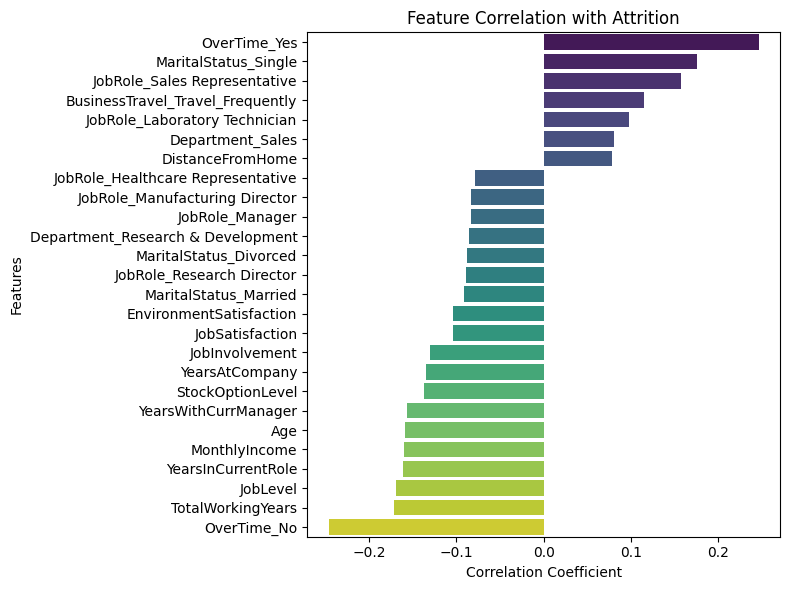

In [3]:
df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)
df = pd.get_dummies(df, drop_first=False)
df.set_index('EmployeeNumber', inplace=True)
plot_corr_bar(df)

/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_150191/4244088750.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette='viridis')


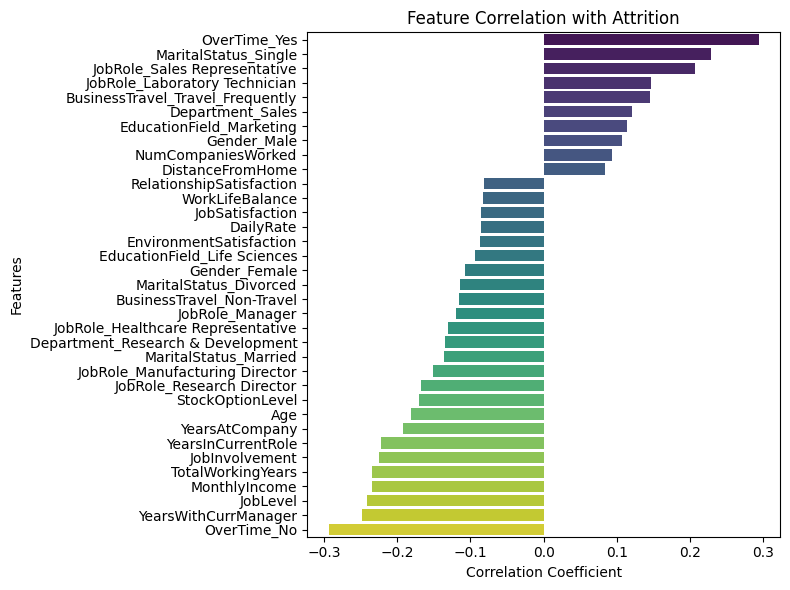

In [4]:
df_balanced = undersample(df, target_col='Attrition')
plot_corr_bar(df_balanced)

In [5]:
df_bool = boolify_ints(df_balanced)

/tmp/ipykernel_150191/4244088750.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_odds_ratios.values()), y=list(sorted_odds_ratios.keys()), palette='magma')


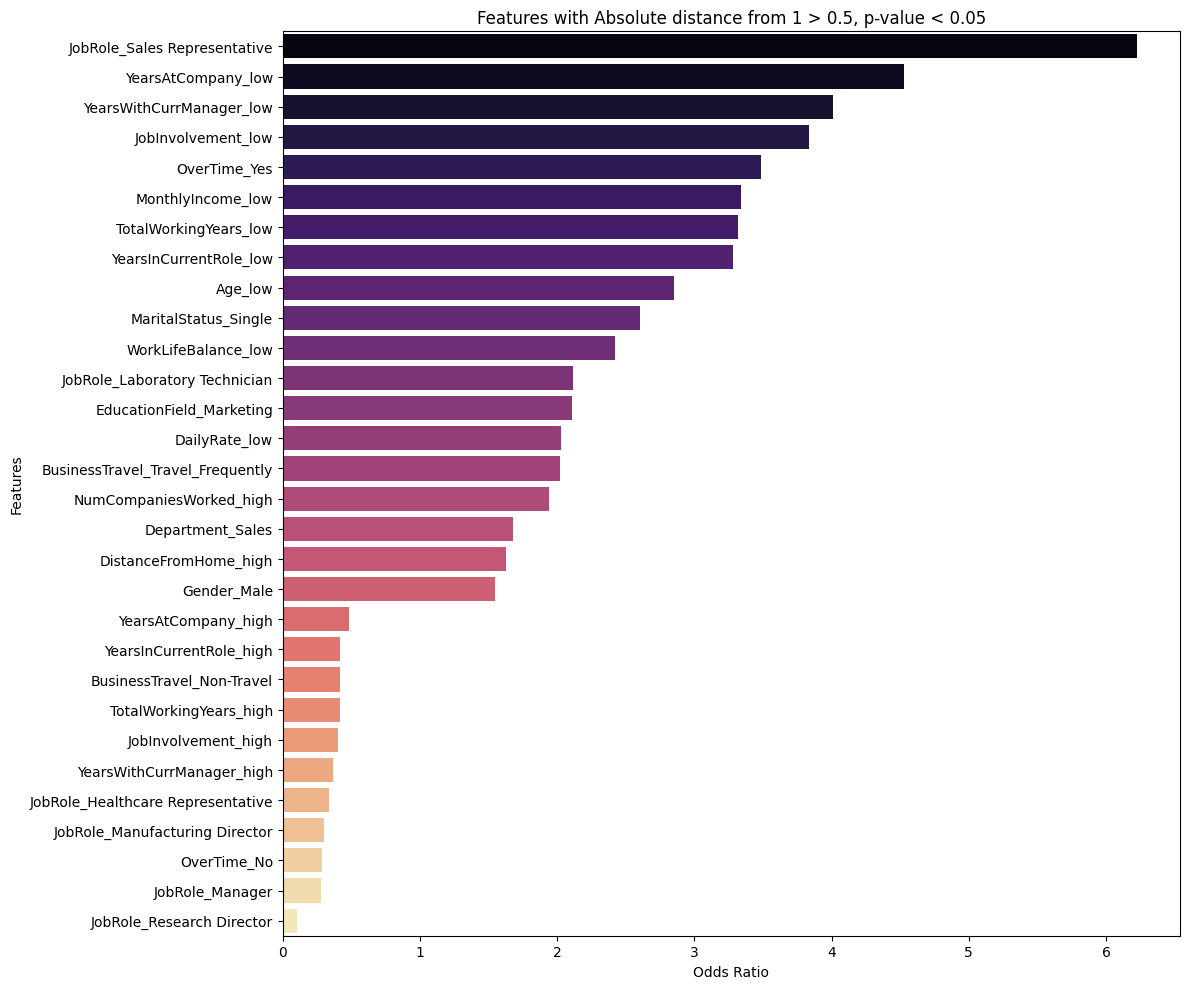

In [6]:
plot_increased_odds_ratio(df_bool, target_col='Attrition', distance_from_one=0.5, p_value_threshold=0.05)